In [1]:
%pip install torch_optimizer > _

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch_optimizer import AdaBound
from torch.nn import functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
BASE_DIR = Path("/kaggle/input/hms-harmful-brain-activity-classification")

EEG_SAMPLING_TIME = 50  #second
EEG_SAMPLING_RATE = 200 #Hz
EEG_DURATION = EEG_SAMPLING_RATE * EEG_SAMPLING_TIME

SPECTROGRAM_TIME = 10   #minute

N_CLASS = 6
CHANNEL = 20
BATCH_SIZE = 128

In [4]:
def set_seed(seed=42):
    np.random.seed(seed)  # 🎲 Set seed for NumPy
    torch.manual_seed(seed)  # 🚀 Set seed for PyTorch on CPU
    torch.cuda.manual_seed(seed)  # 🚀 Set seed for PyTorch on GPU
    
    # ⚙️ When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # 🔏 Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
# 🌱 Set seed using the configured seed value
set_seed()

In [5]:
class HMSDataset(Dataset):
    def __init__(self, df, is_traindir=True, transform=None,):
        self.df = df
        self.is_traindir = is_traindir
        self.transform = transform
        
    def _get_train_eeg(self, q:dict) -> pd.DataFrame:
        parquet_df = pd.read_parquet(BASE_DIR/f"train_eegs/{q['eeg_id']}.parquet")
        eeg_start_index = int(EEG_SAMPLING_RATE * q["eeg_label_offset_seconds"])
        return parquet_df.iloc[eeg_start_index:eeg_start_index+EEG_DURATION]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        q_dict = dict(self.df.iloc[idx])
        if self.is_traindir:
            eeg_df = self._get_train_eeg(q_dict)
        else:
            eeg_df = pd.read_parquet(BASE_DIR/f"test_eegs/{q_dict['eeg_id']}.parquet")
        eeg_df = eeg_df.fillna(0)
        eeg = eeg_df.values.T
        if self.transform:
            eeg = self.transform(eeg)
        label_count = self.df.iloc[idx].filter(like="vote")
        label = label_count/label_count.sum()
        eeg = torch.from_numpy(eeg)
        label = torch.from_numpy(label.astype(np.float16).values)
        return eeg, label


In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet,self).__init__()
        self.conv1 = nn.Conv1d(CHANNEL, 8,kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv1d(8, 16,kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(16)
        self.conv3 = nn.Conv1d(16,64,kernel_size=3, stride=1)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, N_CLASS)

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [7]:
class BrainClassificationDM(pl.LightningDataModule):
    def __init__(
        self,
        df,
        data_transforms,
    ):
        super().__init__()
        self.df = df
        self.data_transforms = data_transforms

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        return N_CLASS

    def setup(self, stage=None):
        patient_ids = self.df['patient_id'].unique()
        train_patient_ids, valid_patient_ids = train_test_split(patient_ids, test_size=0.2, shuffle=True, random_state=42)
        train = self.df[self.df['patient_id'].isin(train_patient_ids)]
        valid = self.df[self.df['patient_id'].isin(valid_patient_ids)]
        self.train_dataset = HMSDataset(train,is_traindir=True,transform=self.data_transforms["train"])
        print(f"training dataset: {len(self.train_dataset)}")
        self.valid_dataset = HMSDataset(valid, is_traindir=True, transform=self.data_transforms["valid"])
        print(f"validation dataset: {len(self.valid_dataset)}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=BATCH_SIZE, 
            num_workers=os.cpu_count(),  # 🔍 Number of workers for data loading
            shuffle=True,   # 🔄 Do not shuffle the data for train set
            pin_memory=True  # 🚀 Pin the memory for faster GPU data transfer
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset, 
            batch_size=BATCH_SIZE, 
            num_workers=os.cpu_count(),  # 🔍 Number of workers for data loading
            shuffle=False,   # 🔄 Do not shuffle the data for train set
            pin_memory=True  # 🚀 Pin the memory for faster GPU data transfer
        )

    def test_dataloader(self):
        pass

    
train_df = pd.read_csv(BASE_DIR/"train.csv")
data_transforms = {
    "train": None,
    "valid": None
}
dm = BrainClassificationDM(
    df=train_df,
    data_transforms=data_transforms,
)
dm.setup()

training dataset: 83684
validation dataset: 23116


In [8]:
class LitCancerSubtype(pl.LightningModule):

    def __init__(self, net, lr: float = 1e-4):
        super().__init__()
        self.net = net
        self.arch = "baseline"
        self.num_classes = N_CLASS
        self.learn_rate = lr

    def forward(self, x):
        y = self.net(x)
        return y

    def compute_loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y.to(y_hat.dtype))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        #print(f"{lbs=} ?= {y_hat=}")
        loss = self.compute_loss(y_hat, y)
        #print(f"{y=} ?= {y_hat=} -> {loss=}")
        self.log("train_loss", loss, logger=True, prog_bar=True)
        #print(f"{lb=} ?= {y_hat=} -> {self.train_accuracy(y_hat, lbs)}")
#         self.log("train_acc", self.train_accuracy(y_hat, y), logger=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.log("valid_loss", loss, logger=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = AdaBound(self.parameters(), lr=self.learn_rate)
        #optimizer = RAdam(self.parameters(), lr=self.learn_rate)
        #optimizer = torch.optim.AdamW(self.parameters(), lr=self.learn_rate)
        #optimizer = Lion(self.parameters(), lr=self.learn_rate, weight_decay=1e-2)
        #optimizer = Adan(self.parameters(), lr=self.learn_rate * 10, betas=(0.02, 0.08, 0.01), weight_decay=0.02)
        
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        #    optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6, verbose=True)
        scheduler = torch.optim.lr_scheduler.CyclicLR(
          optimizer, base_lr=self.learn_rate, max_lr=self.learn_rate * 5,
          step_size_up=5, cycle_momentum=False, mode="triangular2", verbose=True)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #    optimizer, max_lr=self.learn_rate * 5, steps_per_epoch=1, epochs=self.trainer.max_epochs)
        return [optimizer], [scheduler]


net = SimpleNet()
model = LitCancerSubtype(net=net, lr=1e-4)

In [9]:
logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.arch)
nb_epochs = 10
early_stop_metric = "valid_loss"
early_stop_mode = "min"
# ==============================

trainer = pl.Trainer(
    accelerator="cuda",
    # devices=2,
    # fast_dev_run=True,
    # callbacks=[swa],
    # precision=16,
    #val_check_interval=0.5,
    logger=logger,
    min_epochs=3,
    max_epochs=nb_epochs,
    accumulate_grad_batches=1,
    callbacks=[
        EarlyStopping(
            monitor=early_stop_metric,
            min_delta=0.00,
            patience=3,
            verbose=False,
            mode=early_stop_mode,
            )
        ]
)


trainer.fit(model=model, datamodule=dm)
trainer.save_checkpoint("outputs/seq_classification_model.pt")

training dataset: 83684
validation dataset: 23116
Adjusting learning rate of group 0 to 1.0000e-04.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


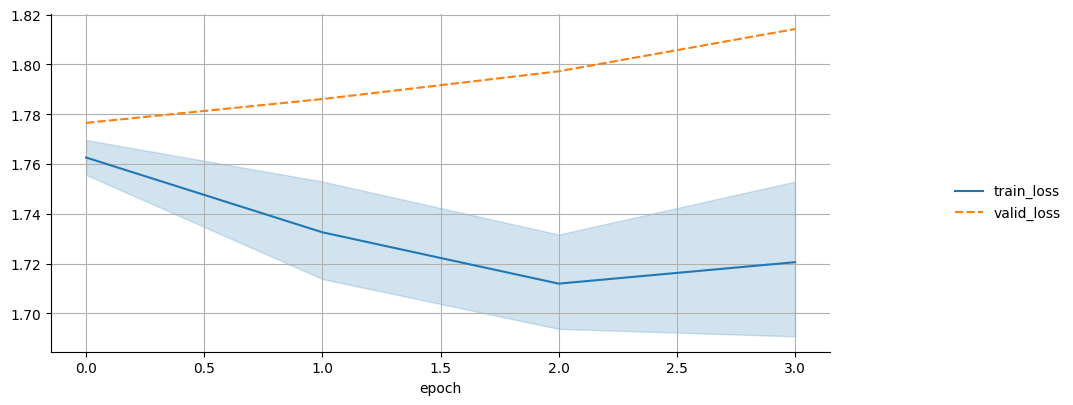

In [10]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
del metrics["step"]
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
g = sns.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
# plt.gca().set_yscale('log')
plt.grid()